## Changelog

1) changed digit image to appear horizontal instead of vertical \
2) output is printed text image instead of sample from data \
3) added conv autoenc to reduce params  \
4) changed the function to generate sums \

## Explanation

Initially I had thought of just picking random numbers from the data, but that would result in maximum samples for 9 as (0,9),(1,8,),(2,7),(3,6),(4,5) all would result in the sum being 9. And minimum samples for 0 (0,0) and 18 (9,9).

To prevent this imbalance in training data, I randomly picked samples whose sum results in a given value going from [0,18]

    while(True):
      num1 = np.random.randint(10)
      num2 = np.random.randint(10)
      if num1 + num2 == sum1:
        break      

But I also realise that doing so would lead to more samples with 0 and 9.

In the current notebook I have used random samples rather than samples based on sum. \
I am not sure which approach would be better. I would be happy to get your feedback regarding this.

## imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# to get and read data
import os
import requests

# for neural network
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy

# for splitting data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# to track progress
from tqdm.notebook import tqdm

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get data

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


download font to print the output (sum of digits) number

In [ ]:
# download font

if not os.path.exists("Arial.ttf"):
    url = "https://github.com/JotJunior/PHP-Boleto-ZF2/raw/master/public/assets/fonts/arial.ttf"
    r = requests.get(url, allow_redirects=True)
    open("Arial.ttf", 'wb').write(r.content)
    print('font downloaded')
else:
    print('font already exists')

font downloaded


In [ ]:
train_inputs, train_labels = zip(*train_dataset)
test_inputs, test_labels = zip(*test_dataset)

def toNumpy(x):
  return np.array([i.numpy().squeeze() for i in x])

train_inputs, train_labels = toNumpy(train_inputs), np.array(train_labels)
test_inputs, test_labels = toNumpy(test_inputs), np.array(test_labels)

print(train_inputs.shape)
print(test_inputs.shape)
print("classes:",np.unique(train_labels))

(60000, 28, 28)
(10000, 28, 28)
classes: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
sum_imgs = []

fnt = ImageFont.truetype('Arial.ttf', 35)
for sum1 in range(19):
  img = Image.new('L', (56, 28))   
  d = ImageDraw.Draw(img)
  d.text((5,-5), str(sum1), font=fnt, fill=255)
  sum_imgs.append(np.array(img))
sum_imgs = np.array(sum_imgs)

### transform data

In [ ]:
def generateSumData(inputs,labels,sum_imgs):

  x1 = inputs
  y1 = labels
  x2, y2 = shuffle(inputs,labels, random_state=0)
  
  inputs2 = np.concatenate((x1,x2), axis=2)
  labels2 = y1 + y2
  outputs2 = sum_imgs[labels2]

  return inputs2, outputs2, labels2

In [ ]:
train_inputs2, train_outputs2, train_labels2 = generateSumData(train_inputs,train_labels,sum_imgs)
test_inputs2, test_outputs2, train_labels2 = generateSumData(test_inputs,test_labels,sum_imgs)

## visualize and verify

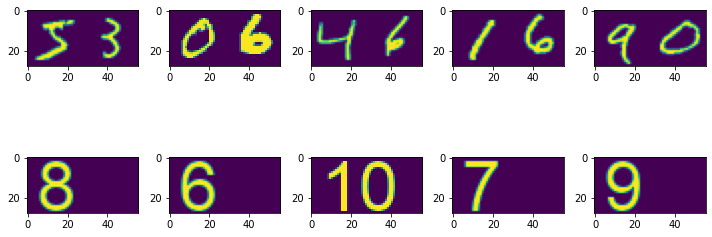

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(10,5))

for i in range(5):
  axs[0][i].imshow(train_inputs2[i])
  axs[1][i].imshow(train_outputs2[i])

plt.tight_layout()
plt.show()

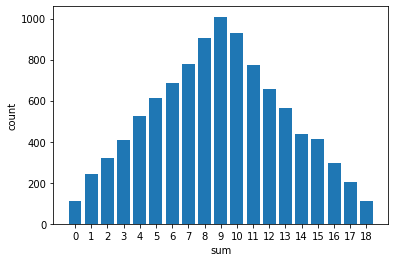

In [ ]:
val, freq = np.unique(train_labels2, return_counts=True)

fig, ax = plt.subplots()
ax.bar(val, freq)
ax.set_xticks(np.arange(len(freq)))
ax.set_xlabel("sum")
ax.set_ylabel("count")
plt.show()

## create dataset and dataloader

In [ ]:
# split train into train and validation
train_inputs2, val_inputs2, train_outputs2, val_outputs2 = train_test_split(train_inputs2, train_outputs2, test_size=0.25, random_state=0)

In [ ]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, outputs, transform):
    self.inputs = inputs
    self.outputs = outputs
    self.transform = transform

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.transform(self.inputs[index])
    output = self.transform(self.outputs[index])
    return input,output
    
transform = torchvision.transforms.ToTensor()
train_dataset = mydataset(train_inputs2, train_outputs2, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_inputs2, val_outputs2, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

test_dataset = mydataset(test_inputs2, test_outputs2, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

dataloaders = {"train":train_loader, "val":val_loader}

## define autoencoder

In [ ]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,outTrueBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):

          inputBatch = inputBatch.to(device).float()
          outTrueBatch = outTrueBatch.to(device).float()

          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outPredBatch = model(inputBatch)
          loss = criterion(outTrueBatch, outPredBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.4f" % (phase, avg_loss[phase]), end=", ")
      print(" | ", end='')
      for phase in phases:        
        print("avg %s loss: %.4f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  last_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, last_params

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
      nn.Linear(56 * 28, 128),  nn.ReLU(inplace=True),
      nn.Linear(128, 64),       nn.ReLU(inplace=True),
      nn.Linear(64, 25))
    
    self.decoder = nn.Sequential(
      nn.Linear(25, 64),  nn.ReLU(inplace=True), 
      nn.Linear(64, 128), nn.ReLU(inplace=True), 
      nn.Linear(128, 56 * 28))

  def forward(self, x):
    size = x.size()
    x = x.view(-1, np.prod(size[1:]))
    x = self.encoder(x)
    x = self.decoder(x)
    x = x.view(size)
    return x

In [ ]:
class Interpolate(nn.Module):
    def __init__(self, size, mode="nearest"):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode)
        return x

class ConvAutoEncoder(nn.Module):
  def __init__(self):
    super(ConvAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(                     # 28,56
      nn.Conv2d(1, 4, 3, stride=2),   nn.ReLU(True),  # 13,27
      nn.Conv2d(4, 8, 3, stride=2),   nn.ReLU(True),  # 6,13
      nn.Conv2d(8, 16, 3, stride=1),  nn.ReLU(True),  # 4,11
      #nn.AdaptiveAvgPool2d(5)
    )
    self.latent = nn.Sequential(
      nn.Linear(16*11*4,64),  nn.ReLU(True),
      nn.Linear(64,32),       nn.ReLU(True),
      nn.Linear(32,25),       nn.ReLU(True),
      nn.Linear(25,32),       nn.ReLU(True),
      nn.Linear(32,64),       nn.ReLU(True),
      nn.Linear(64,16*11*4),  nn.ReLU(True), 
    )
    self.decoder = nn.Sequential(  
      #Interpolate((11,4)),
      nn.ConvTranspose2d(16, 8, 3, stride=1),   nn.ReLU(True),
      nn.ConvTranspose2d(8, 4, 3, stride=2),    nn.ReLU(True),
      nn.ConvTranspose2d(4, 1, 4, stride=2)
    )

  def forward(self, x):
    x = self.encoder(x)

    size = x.size()
    x = x.view(-1, np.prod(size[1:]))
    x = self.latent(x)
    x = x.view(size)

    x = self.decoder(x)
    return x

In [ ]:
model = ConvAutoEncoder().to(device)
print("params:",sum(p.numel() for p in model.parameters() if p.requires_grad))

#Define a Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

params: 99750


training model


epoch: 5  | train loss: 0.0327, val loss: 0.0324,  | avg train loss: 0.0466, avg val loss: 0.0429, 

epoch: 10  | train loss: 0.0190, val loss: 0.0200,  | avg train loss: 0.0234, avg val loss: 0.0240, 

epoch: 15  | train loss: 0.0144, val loss: 0.0168,  | avg train loss: 0.0159, avg val loss: 0.0180, 

epoch: 20  | train loss: 0.0125, val loss: 0.0151,  | avg train loss: 0.0132, avg val loss: 0.0162, 

epoch: 25  | train loss: 0.0110, val loss: 0.0146,  | avg train loss: 0.0115, avg val loss: 0.0150, 

epoch: 30  | train loss: 0.0101, val loss: 0.0135,  | avg train loss: 0.0105, avg val loss: 0.0143, 

epoch: 35  | train loss: 0.0094, val loss: 0.0138,  | avg train loss: 0.0097, avg val loss: 0.0138, 

epoch: 40  | train loss: 0.0088, val loss: 0.0132,  | avg train loss: 0.0091, avg val loss: 0.0132, 

epoch: 45  | train loss: 0.0085, val loss: 0.0136,  | avg train loss: 0.0086, avg val loss: 0.0129, 

epoch: 50  | train loss: 0.0080, val loss: 0.0125,  | avg train loss: 0.0081, avg val loss: 0.0128, 
Finished Training


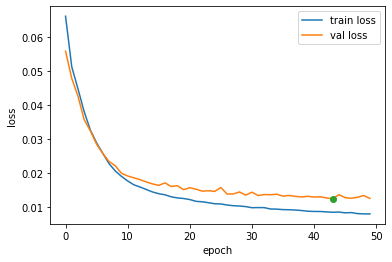

In [ ]:
best_params, last_params = train_model(model, criterion, optimizer, dataloaders, epochs=50)

In [ ]:
model.load_state_dict(best_params)

<All keys matched successfully>

## evaluate

In [ ]:
def evaluate(model,inputs,transform,n_samples=5):
  model.eval()
  
  fig, axs = plt.subplots(2,n_samples, figsize=(10,5))
  for i,input in enumerate(inputs[:n_samples]):
      axs[0][i].imshow(input)
      input = transform(input).unsqueeze(0).to(device).float()
      with torch.no_grad():
        output = model(input)
      output = output.view(input.shape[1:]).squeeze().cpu()
      axs[1][i].imshow(output)
  plt.show()

train sample visualized


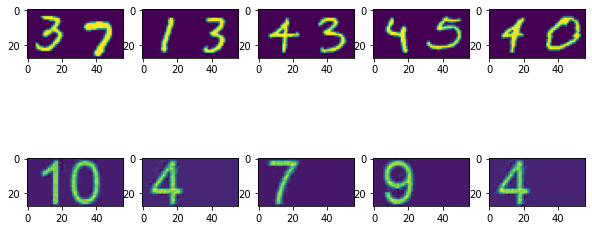

test sample visualized


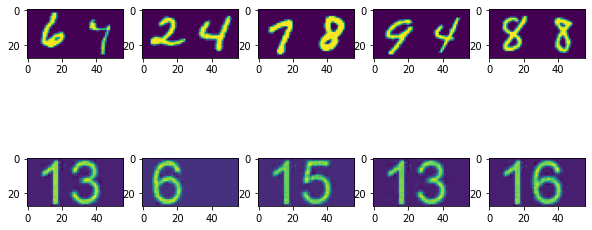

In [ ]:
print("train sample visualized")
evaluate(model,train_inputs2,transform)
print("test sample visualized")
randTestSamples = test_inputs2[np.random.choice(test_inputs2.shape[0],5,replace=False)]
evaluate(model,randTestSamples,transform)